In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.activations import relu, tanh, sigmoid, softmax

In [36]:
crop_data = pd.read_csv('/tmp/Crop_recommendation.csv')
crop_data.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
crop_data['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

## Build the Model

In [37]:
selected_label = 'papaya' #'rice'
selected_dataset = crop_data.loc[crop_data['label']==selected_label]

deleted_label = crop_data[crop_data['label']==selected_label].index.values
crop_data.drop(deleted_label, axis=0, inplace=True)
random_dataset = crop_data.sample(n=100)

dataset_list = [selected_dataset, random_dataset]
concate_dataset = pd.concat(dataset_list)

print(concate_dataset)

       N    P    K  temperature   humidity        ph    rainfall   label
1700  61   68   50    35.214628  91.497251  6.793245  243.074507  papaya
1701  58   46   45    42.394134  90.790281  6.576261   88.466075  papaya
1702  45   47   55    38.419163  91.142204  6.751453  119.265388  papaya
1703  39   65   53    35.332949  92.115086  6.560743  235.613359  papaya
1704  31   68   45    42.923253  90.076005  6.938313  196.240824  papaya
...   ..  ...  ...          ...        ...       ...         ...     ...
1287  29  122  196    41.948657  81.155952  5.638328   73.068630  grapes
2164  92   40   30    23.357232  55.187922  6.026287  171.697695  coffee
184   61   59   17    23.338446  59.245806  6.474443  105.008314   maize
2149  82   29   35    26.673772  52.242263  6.246872  156.154390  coffee
803   11   74   17    21.363838  69.923759  6.633865   46.635286  lentil

[200 rows x 8 columns]


In [38]:
features = ['temperature', 'humidity', 'rainfall']

dataset = concate_dataset
y = dataset.pop('label')
X = pd.DataFrame([dataset.pop(x) for x in features]).T

In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

print('Num Label: ', y)
print('Word Label: ', le.inverse_transform(y))
# See the first 5 observations of X and y
# X.head()
# y.head()

Num Label:  [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 13  3 16  1  3 21  5 13 15 15  8  0 13 10  2 20  4 14  3 21
  0  1 16  1 16 19  7 14 18 15  8 11 12  0 18  8 21  5  3 16 14 10  8 12
  7  2 15  1 11 10 10 19 12 13 19  8 14  0  9  3  6 15 16  8 16  3 12  6
  3 11 19 20  9  6 15 14 20 13 21 21  4  3  4  3  6 19  5 19 11 15 19 18
  7 20 14  7  5 11  5 10]
Word Label:  ['papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya'
 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya'
 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya'
 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya'
 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya' 'papaya'


In [40]:
# Perform splitting training and testing data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Number of training data: ', X_train.shape[0])
print('Number of testing data: ', X_test.shape[0])

Number of training data:  160
Number of testing data:  40


In [23]:
# Show first 5 data of training
X_train.head()

# Show first 5 data of testing
#X_test.head()

,temperature,humidity,rainfall
79,22.678461,83.728744,200.913316
744,28.840792,63.372307,70.254967
38,21.019447,82.952217,298.401847
24,23.483813,81.332651,224.058116
1449,27.290357,90.533301,23.495352


In [41]:
# Perform feature scaling

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Hyperparameter Tuning

In [42]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [43]:

def create_model(layers, activation):
    model = Sequential()
    for i, neurons in enumerate(layers):
        if i==0:
            model.add(Dense(neurons, input_dim=X_train.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(neurons))
            model.add(Activation(activation))
    model.add(Dense(22, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

print('')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [45]:

layers = [[64, 64, 64], [64, 64, 128], [256, 256, 256]]
# layers = [[256, 256, 256]]
activations = ['relu', 'tanh']
param_grid = dict(layers=layers, activation=activations, batch_size=[32, 64], epochs=[70])
grid = GridSearchCV(estimator=model, param_grid=param_grid)


grid_result = grid.fit(X_train, y_train)

[grid_result.best_score_, grid_result.best_params_]

print([grid_result.best_score_, grid_result.best_params_])

[0.7875, {'activation': 'tanh', 'batch_size': 32, 'epochs': 70, 'layers': [256, 256, 256]}]


In [46]:
model = Sequential([
    Flatten(),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(22, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [47]:
# Fitting the model
# Note: Change verbose to 1, to see fitting details per epoch

history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), batch_size=32, verbose = 1)

Epoch 1/300
5/5 [==============================] - 1s 56ms/step - loss: 2.6101 - accuracy: 0.3500 - val_loss: 1.9499 - val_accuracy: 0.6000
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 1.7390 - accuracy: 0.5938 - val_loss: 1.6151 - val_accuracy: 0.6000
Epoch 3/300
5/5 [==============================] - 0s 11ms/step - loss: 1.3694 - accuracy: 0.5938 - val_loss: 1.4044 - val_accuracy: 0.6500
Epoch 4/300
5/5 [==============================] - 0s 11ms/step - loss: 1.2007 - accuracy: 0.6375 - val_loss: 1.3017 - val_accuracy: 0.6500
Epoch 5/300
5/5 [==============================] - 0s 13ms/step - loss: 1.0699 - accuracy: 0.6687 - val_loss: 1.2041 - val_accuracy: 0.6500
Epoch 6/300
5/5 [==============================] - 0s 12ms/step - loss: 0.9891 - accuracy: 0.6625 - val_loss: 1.1222 - val_accuracy: 0.7500
Epoch 7/300
5/5 [==============================] - 0s 13ms/step - loss: 0.9245 - accuracy: 0.7375 - val_loss: 1.0556 - val_accuracy: 0.7500
Epoch 8/300
5/5 [===

In [ ]:
# Save and convert the model
import pathlib

export_dir = '/tmp/'
tf.saved_model.save(model, export_dir=export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
# converter.optimizations = [optimization]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/tmp/reduction-crop-recommendation-prediction.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /tmp/assets


INFO:tensorflow:Assets written to: /tmp/assets


19048

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# List all metrics
metrics = [acc, val_acc, loss, val_loss]
names = ['Training Accuracy', 'Testing Accuracy', 'Training Loss', 'Testing Loss']

for i in range(len(metrics)):
    print ('Final {}: {:.3f}'.format(names[i], metrics[i][-1]))

Final Training Accuracy: 0.994
Final Testing Accuracy: 0.775
Final Training Loss: 0.018
Final Testing Loss: 1.410


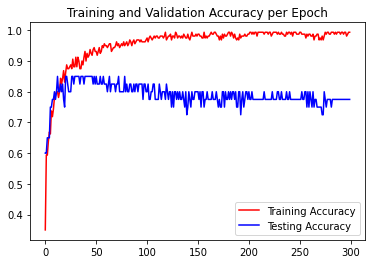

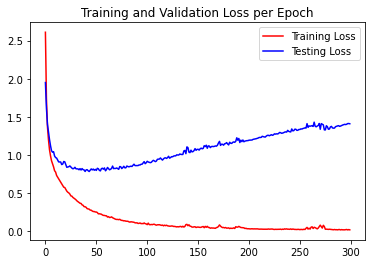

In [49]:
# Initialize x-axis and its naught value

epochs = range(len(acc))
start = 0 # Change 'start' variable to change the naught value
end = epochs[-1] + 1

# Plot training and validation accuracy per epoch
plt.plot(epochs[start:end], acc[start:end], 'r', label='Training Accuracy')
plt.plot(epochs[start:end], val_acc[start:end], 'b', label='Testing Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend(loc=0)
plt.show()

# Plot training and validation loss per epoch
plt.plot(epochs[start:end], loss[start:end], 'r', label='Training Loss')
plt.plot(epochs[start:end], val_loss[start:end], 'b', label='Testing Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend(loc=0)
plt.show()

## Only Sort Output Based on Probability

In [ ]:
# Prediction only applied for Scalable Data
def scaled_predict(inputs, threshold=0.1):
    
    counter = 0
    
    # Get all probabilities for each label
    y_pred = model.predict(inputs)
    
    # Insert corresponding label to labels list
    for probs in y_pred:
        counter += 1
        
        # List of labels that transcend some threshold
        index = np.where(probs > threshold)[0]
        print('Recommendation {}: {}'.format(counter, ', '.join(le.inverse_transform(index))))
        
# Prediction only applied before data scalable        
def predict(inputs, threshold=0.1):
    
    # Feature Scaling by StandardScaler
    inputs = sc.transform(inputs)
    
    # Use scaled_predict function
    scaled_predict(inputs, threshold)

In [ ]:
scaled_predict(X_test)

Recommendation 1: muskmelon
Recommendation 2: watermelon
Recommendation 3: papaya
Recommendation 4: orange
Recommendation 5: apple
Recommendation 6: mango
Recommendation 7: apple, orange, pomegranate
Recommendation 8: mothbeans
Recommendation 9: mungbean
Recommendation 10: lentil
Recommendation 11: blackgram
Recommendation 12: coconut
Recommendation 13: pomegranate
Recommendation 14: jute
Recommendation 15: coconut
Recommendation 16: orange, papaya, pomegranate
Recommendation 17: apple, orange, pomegranate
Recommendation 18: maize
Recommendation 19: coconut, papaya
Recommendation 20: muskmelon
Recommendation 21: coffee
Recommendation 22: papaya
Recommendation 23: orange
Recommendation 24: coconut, papaya
Recommendation 25: chickpea, kidneybeans
Recommendation 26: jute
Recommendation 27: mungbean, watermelon
Recommendation 28: orange
Recommendation 29: coffee
Recommendation 30: jute, rice
Recommendation 31: orange, pomegranate
Recommendation 32: lentil, mothbeans
Recommendation 33: jute

## Sorting Probabilities and Corresponding Index

In [ ]:
# Prediction only applied for Scalable Data
def scaled_predict(inputs):
    
    counter = 0
    
    # Get all probabilities for each label
    y_pred = model.predict(inputs)
    
    # Insert corresponding label to labels list
    for probs in y_pred:
        counter += 1 
        
        index = [i for i in range(len(probs))]
        
        # Sorted probs (descending)
        sorted_probs = list(np.sort(probs)[::-1])
        
        # Convert np.array probs to list
        probs = list(probs)
        
        # Indexes after sorted by probs
        sorted_index = [probs.index(prob) for prob in sorted_probs]
        
        print('Recommendation {}: {}'.format(counter, ', '.join(le.inverse_transform(sorted_index))))
        print('Probabilities: {}'.format(sorted_probs))
        print('')
        
# Prediction only applied before data scalable        
def predict(inputs, threshold=0.1):
    
    # Feature Scaling by StandardScaler
    inputs = sc.transform(inputs)
    
    # Use scaled_predict function
    scaled_predict(inputs, threshold)

In [ ]:
# Test it for yourself

scaled_predict(X_test)

Recommendation 1: muskmelon, mungbean, papaya, watermelon, orange, grapes, cotton, mothbeans, blackgram, apple, apple, apple, apple, apple, apple, apple, apple, apple, apple, apple, apple, apple
Probabilities: [0.9999057, 9.392223e-05, 4.0042303e-07, 2.2084405e-12, 1.4182216e-24, 1.6548997e-28, 1.1341746e-30, 3.2338063e-33, 4.223972e-34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Recommendation 2: watermelon, mungbean, cotton, grapes, papaya, orange, muskmelon, blackgram, mothbeans, lentil, maize, banana, pigeonpeas, kidneybeans, apple, pomegranate, chickpea, chickpea, chickpea, chickpea, chickpea, chickpea
Probabilities: [0.9999646, 3.425548e-05, 7.1041643e-07, 2.9735378e-07, 9.2315794e-08, 2.8651257e-13, 5.3350624e-14, 7.277538e-17, 3.7964202e-17, 4.3436066e-19, 2.6092862e-19, 1.84686e-21, 6.626408e-22, 1.8969147e-27, 4.729804e-33, 4.974121e-34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Recommendation 3: papaya, orange, grapes, coconut, banana, pigeonpeas, blackgram, pome